# Takeaways

- ARGO exists but the access method is non-automated
- We cover a search and data request here...
- ...and data retrieval with Python ftp


# CAHW 4 ARGO 

This library sits on GitHub of course; and it is intended to be some'th cut at being an ARGO tool. 
Let's also include some other ARGO references.

- [GitHub pyARGO](https://github.com/castelao/pyARGO) Rob is not convinced this is complete enough to be useful...
- [UCSD ARGO Informational FAQ](http://www.argo.ucsd.edu/Data_FAQ.html#RorD)
- [Coriolis map-based data selection tool](http://www.argodatamgt.org/Access-to-data/Argo-data-selection)
- [xarray lesson that works with ARGO data](https://rabernat.github.io/research_computing/xarray.html)

In [4]:
# Some Python utility code
from pathlib import Path
home_d = str(Path.home()) + '/'
data_d = home_d + 'data/'             # A non-repository location for datasets of interest

def dirobj(obj): return [x for x in dir(obj) if not x.startswith('__')]

def lsal(path=''):
    import os
    return os.popen('ls -al ' + path).readlines()

def ShowGitHubImage(username, repo, folder, source, localpath, localname, width, height):
    global home_d
    import requests, shutil
    from PIL import Image
    outf = localpath + '/' + localname
    f = 'https://raw.githubusercontent.com/' + username + '/' + repo + '/master/' + folder + '/' + source
    a = requests.get(f, stream = True)
    if a.status_code == 200:
        with open(outf, 'wb') as f:
            a.raw.decode_content = True
            shutil.copyfileobj(a.raw, f)
    return Image.open(outf).resize((width,height),Image.ANTIALIAS)

def ShowLocalImage(path, filename, width, height):
    from PIL import Image
    f = path + '/' + filename 
    return Image.open(f).resize((width,height),Image.ANTIALIAS)

# Test either of the 'Show Image' functions
# ShowGitHubImage('robfatland', 'othermathclub', 'images/cellular', 'conus_textile_shell_2.png', home_d, 'ctextile.jpg', 450, 250)
# ShowLocalImage(home_d, 'ctextile.jpg', 450, 250)

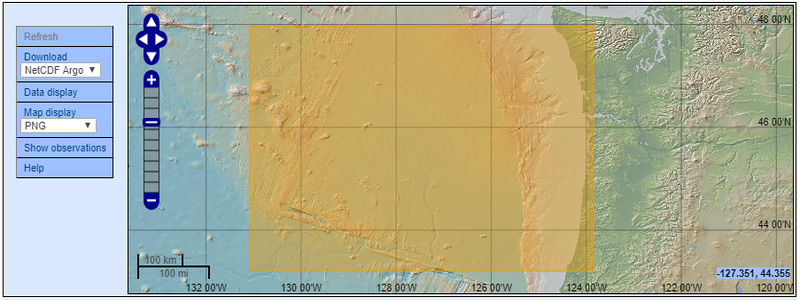

In [7]:
argo_d = data_d + 'argo/'
ShowLocalImage(data_d + 'images/','ARGO_BB_selection.png',800,300)

Coriolis (ARGO data selection tool) reports back (from a 3-month time window search + download)...

```
We are processing your data request.
The data will be delivered: ftp://ftp.ifremer.fr/ifremer/coriolis/tmp/co0501/DataSelection_20180206_225551_5097076.tgz
```

### Select a dataset 

- Use the map interface to select (as above, yellow rectangle) a bounding box. 
- Use the time box to select a time range
- Click on Refresh (control left of map), wait for Query to complete
- Click (or double click?) on Download to open the Data Selection tab in your browser. 
  - This click seems a bit inconsistent... it does not always work
- Enter your email, click the 'Extract your data' button 
- Receive a 'processing' confirmation email
- Receive an email with a link to the dataset

I searched for Jan 1 -- June 30 2016. In a matter of five minutes I received a link by email:

```
ftp://ftp.ifremer.fr/ifremer/coriolis/tmp/co0501/DataSelection_20180221_193406_5147072.tgz
```

Now this file will expire and vanish in an hour or two. When it does the ftp call (cell below) will return

```
221 Goodbye
```

So grab that data before it evaporates; and then put it somewhere stable.

In [8]:
# Jan 1 to June 30 2016 returned...
# ftp://ftp.ifremer.fr/ifremer/coriolis/tmp/co0501/DataSelection_20180221_193406_5147072.tgz
# July 1 to Dec 31 2016...
# ftp://ftp.ifremer.fr/ifremer/coriolis/tmp/co0501/DataSelection_20180221_194041_5147085.tgz,
from ftplib import FTP
dataIDString = '20180221_194041_5147085'
myIDString = './ARGO_Jul1_Dec31_2016.tgz'
ftp = FTP('ftp.ifremer.fr')
ftp.login()
ftp.cwd('ifremer/coriolis/tmp/co0501/')
ftp.retrlines('LIST DataSelection_' + dataIDString + '.tgz')
ftp.retrbinary('RETR DataSelection_' + dataIDString + '.tgz', open(myIDString, 'wb').write)
ftp.quit()

error_perm: 550 Failed to open file.

In [5]:
import os

def ls(qual):
    return os.popen('ls -al ' + qual).readlines()
    
datasetList = []
r = ls('*.tgz')
for a in r: 
    c = a.split(' ')[8].split('.')[0]
    if c not in datasetList: datasetList.append(c)
        
print(str(datasetList))

['ARGO_Jul1_Dec31_2016']


In [7]:
for c in datasetList:
    retvalue = os.popen('gunzip ' + c + '.tgz').readlines()
    retvalue = os.popen('tar -xvf ' + c + '.tar').readlines()
# !tar -xvf coriolis_profiles.tgz
# !rm /data/argo/coriolis_profiles.tgz
# !mkdir /data/argo/profiles
# !mkdir /data/argo/trajectories

In [8]:
# Broken... skip this for now
# import anaconda
# from argo.argo import profile_from_nc
# from argo.utils import download_testdata
# datafile = download_testdata('20150127_prof.nc')

## ARGO Data

The main data resource is a pair of Global Data Assembly Centers (GDACs) in US and France. 
The data are in NetCDF format and one should use 'D' files when possible (in contrast with 'R' files): 
These D files have been post-processed (quality control).


There are other ways to access Argo data besides downloading the netCDF files from the GDACs. 
There are gridded fields and velocity products available as well as data viewers developed to look at the Argo dataset. 
To look at individual float data, use the individual float description tool at Coriolis. 
To select a group of floats within a certain region or time, use one of the data selection tools to the right. 
There is also a beginner's guide to Argo data.

In [19]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import netCDF4
import xarray as xr
import numpy as np

argo_d = data_d + 'argo/'
r = lsal(argo_d)
b=[a.split()[8] for a in r if len(a.split()) == 9 and a.split()[8][-3:] == '.nc']


['argo-profiles-4901187.nc',
 'argo-profiles-4901531.nc',
 'argo-profiles-4901559.nc',
 'argo-profiles-4901768.nc',
 'argo-profiles-4902314.nc',
 'argo-profiles-5903601.nc',
 'argo-profiles-5904283.nc',
 'argo-profiles-5904458.nc',
 'argo-profiles-5904459.nc']

In [11]:
r
fl = []
ds = []
for a in r:
    b = a.split(' ')   
    for c in b:
        if 'argo-' in c:
            d = c.split('/')[2]
            if d not in fl: 
                fl.append(d.rstrip('\n'))
                f = './argo/' + fl[-1]
                # print(f)
                ds.append(xr.open_mfdataset(f))

# dir(ds[0])
ds[0].keys

IndexError: list index out of range

In [40]:
ds[0].keys
df = ds[0]['TEMP'].to_dataframe()

CPU times: user 136 ms, sys: 0 ns, total: 136 ms
Wall time: 121 ms


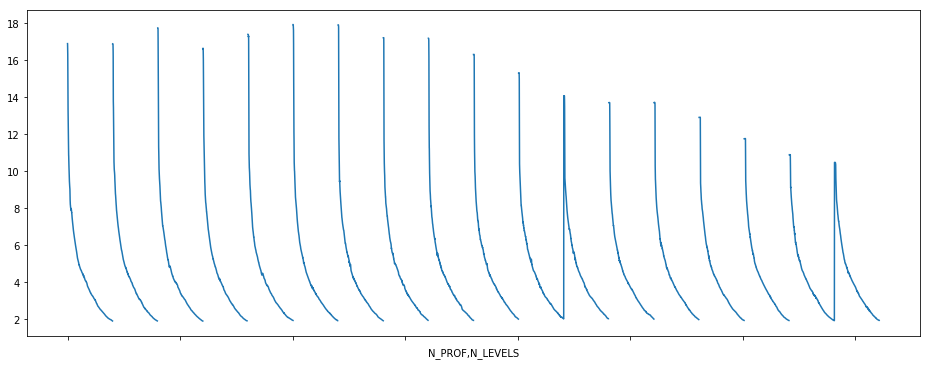

In [44]:
%%time
plt.close()
fig,ax = plt.subplots()
fig.set_size_inches(16,6)
df['TEMP'].plot()

In [21]:
U = c['PRES']
dir(U)
# U.plot()

['C_format',
 'FORTRAN_format',
 'N_LEVELS',
 'N_PROF',
 'T',
 '_DataArray__default',
 '_DataArray__default_name',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_priority__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__complex__',
 '__contains__',
 '__copy__',
 '__dask_graph__',
 '__dask_keys__',
 '__dask_optimize__',
 '__dask_postcompute__',
 '__dask_postpersist__',
 '__dask_scheduler__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__long__',
 '__lt__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg_

In [22]:
dir(U.T)

['C_format',
 'FORTRAN_format',
 'N_LEVELS',
 'N_PROF',
 'T',
 '_DataArray__default',
 '_DataArray__default_name',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_priority__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__complex__',
 '__contains__',
 '__copy__',
 '__dask_graph__',
 '__dask_keys__',
 '__dask_optimize__',
 '__dask_postcompute__',
 '__dask_postpersist__',
 '__dask_scheduler__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__long__',
 '__lt__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg_

In [23]:
dir(U.data)

['A',
 'T',
 '__abs__',
 '__abstractmethods__',
 '__add__',
 '__and__',
 '__array__',
 '__array_priority__',
 '__array_ufunc__',
 '__bool__',
 '__class__',
 '__complex__',
 '__dask_graph__',
 '__dask_keys__',
 '__dask_optimize__',
 '__dask_postcompute__',
 '__dask_postpersist__',
 '__dask_scheduler__',
 '__dask_tokenize__',
 '__deepcopy__',
 '__delattr__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__le__',
 '__len__',
 '__long__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rlshift__',
 '__rmatmul__',
 '__rmod__',
 '__rmul__',
 '__ror__',
 '__rpow__',
 '__rrshift__',
 '__rshift

In [24]:
U.data.plot()

AttributeError: 'Array' object has no attribute 'plot'

In [25]:
b.PRES.plot()

AttributeError: 'NpzFile' object has no attribute 'PRES'

In [26]:
print (b['PRES'])

KeyError: 'PRES is not a file in the archive'

In [27]:
dir(b['PRES'])

KeyError: 'PRES is not a file in the archive'

In [28]:
dir(b['PRES']['data'])

KeyError: 'PRES is not a file in the archive'

In [29]:
b.keys()

['S', 'T', 'levels', 'lon', 'date', 'P', 'lat']

In [30]:
print(b.psal.shap())

AttributeError: 'NpzFile' object has no attribute 'psal'